In [19]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [20]:
# plt.rcParams['figure.figsize'] = (15,10)
# plt.rcParams['figure.dpi'] = 100

In [21]:
true_temp_df = pd.read_csv("csv_files/weather.csv", usecols=['temp', 'dt', 'today'], dtype={'dt': 'int64'})
forecast_temp_df = pd.read_csv("csv_files/forecast.csv", usecols=['temp', 'dt', 'today'], dtype={'dt': 'int64'})
temp_data_df = pd.read_csv("csv_files/join.csv", usecols=['temp', 'dt', 'today', 't5', 't4', 't3', 't2', 't1'])
metrics_df = pd.read_csv("csv_files/metrics.csv")

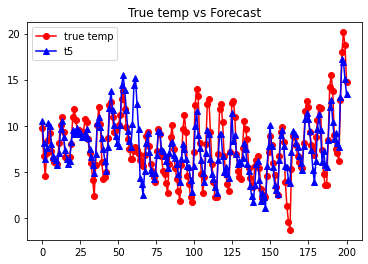

In [22]:
min_x = 800
max_x = 1000
N = temp_data_df.shape[0]
x = np.linspace(0,max_x-min_x,max_x-min_x)
plt.plot(x, temp_data_df['temp'][min_x:max_x], label='true temp', color='red', marker='o')
plt.plot(x, temp_data_df['t5'][min_x:max_x], label='t5', color='blue', marker='^')
# plt.plot(x, temp_data_df['t4'][min_x:max_x], label='t4', color='grey', marker='^')
# plt.plot(x, temp_data_df['t3'][min_x:max_x], label='t3', color='purple', marker='|')
# plt.plot(x, temp_data_df['t2'][min_x:max_x], label='t2', color='orange', marker='|')
# plt.plot(x, temp_data_df['t1'][min_x:max_x], label='t1', color='green', marker='*')
plt.title("True temp vs Forecast")
plt.legend()
plt.show()

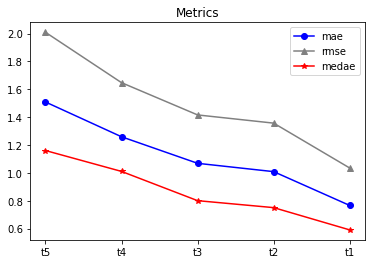

In [23]:
# plt.rcParams['figure.figsize'] = (7,3)
x = np.linspace(0,1,5)
axes= plt.axes()
axes.set_xticks(x)
axes.set_xticklabels(['t5', 't4', 't3', 't2', 't1'])
plt.plot(x, metrics_df['mae'], label='mae', color='blue', marker='o')
plt.plot(x, metrics_df['rmse'], label='rmse', color='grey', marker='^')
plt.plot(x, metrics_df['medae'], label='medae', color='red', marker='*')
plt.title("Metrics")
plt.legend()
plt.show()

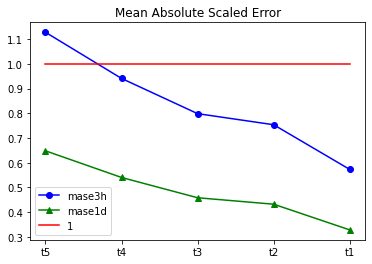

In [24]:
x = np.linspace(0,1,5)
axes= plt.axes()
axes.set_xticks(x)
axes.set_xticklabels(['t5', 't4', 't3', 't2', 't1'])
plt.plot(x, metrics_df['mase'], label='mase3h', color='blue', marker='o')
plt.plot(x, metrics_df['mase1d'], label='mase1d', color='green', marker='^')
plt.plot(x, np.ones(5), label='1', color='red')
plt.title("Mean Absolute Scaled Error")
plt.legend()
plt.show()

In [25]:
true_temp_df.describe()

,temp,dt
count,1101.000000,1.101000e+03
mean,7.297866,1.580850e+09
std,3.628983,3.434137e+06
min,-1.720000,1.574910e+09
25%,5.150000,1.577880e+09
50%,7.180000,1.580850e+09
75%,9.350000,1.583820e+09
max,23.330000,1.586790e+09


In [26]:
true_temp_df

,temp,dt,today
0,8.19,1574910000,2019-11-28
1,8.19,1574920800,2019-11-28
2,7.93,1574931600,2019-11-28
3,9.36,1574942400,2019-11-28
4,9.32,1574953200,2019-11-28
5,8.54,1574964000,2019-11-28
6,7.31,1574974800,2019-11-28
7,6.23,1574985600,2019-11-29
8,5.33,1574996400,2019-11-29
9,3.65,1575007200,2019-11-29


In [27]:
true_temp_df['today'].unique()

array(['2019-11-28', '2019-11-29', '2019-11-30', '2019-12-01',
       '2019-12-02', '2019-12-03', '2019-12-04', '2019-12-05',
       '2019-12-06', '2019-12-07', '2019-12-08', '2019-12-09',
       '2019-12-10', '2019-12-11', '2019-12-12', '2019-12-13',
       '2019-12-14', '2019-12-15', '2019-12-16', '2019-12-17',
       '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-21',
       '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
       '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
       '2019-12-30', '2019-12-31', '2020-01-01', '2020-01-02',
       '2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06',
       '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
       '2020-01-11', '2020-01-12', '2020-01-13', '2020-01-14',
       '2020-01-15', '2020-01-16', '2020-01-17', '2020-01-18',
       '2020-01-19', '2020-01-20', '2020-01-21', '2020-01-22',
       '2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26',
       '2020-01-27', '2020-01-28', '2020-01-29', '2020-